# Machine learning reveals systematic accumulation ofelectric current in lead-up to solar flares
### Dattaraj, D. B. et al. Machine learning reveals systematic accumulation of electric current in lead-up to solar flares. PNAS http://dx.doi.org/10.1073/pnas.1820244116 (2019).

## Downloading SHARPs data from JSOC 

In [1]:
import downloader
import processor
import trainer
import numpy as np
import glob
import matplotlib
%matplotlib inline
import pylab as pl
from matplotlib.ticker import FormatStrFormatter

In [2]:
#Globals
dataPath = 'Data'
sharpName = 'sharpData'
flareName = 'flareData'
nFeatures = 12

featAbb = ['USFLUX','AREA','TOTUSJZ','TOTUSJH','TOTPOT','TOTBSQ','ABSNJZH','SAVNCPP','R_VALUE','MEANPOT',
         'SHRGT45','TOTFZ']
featUnits = [r'$(10^{22} Mx)$',r'$(Mm^2)$',r'$(10^{13} A)$',r'$(10^2 G^2-m^{-1})$',r'$(10^{23} erg-cm^{-1})$',
           r'$10^{10} (G^2)$',r'$(G^2-m^{-1})$',r'$(10^{13} A)$',r'$(Mx)$',r'$(10^2 erg-cm^{-3})$','(%)',
           r'$(10^{23} dyne)$']
features=['Unsigned Flux','Area of active region','Unsigned Vertical Current','Unsigned Current Helicity',
          'Total Free Energy','Lorentz force magnitude','Absolute Net Current Helicity',
          'Sum of Net Current Per Polarity','Flux near polarity inversion line','Mean Free Energy',
          'Area With Shear > 45 Deg','Z Lorentz force']
featScales = [1.0e22,1.0/(0.380*0.380),1.0e13,100.0,1.0e23,1.0e10,1.0,1.0e13,1.0,100.0,1.0,1000.0]

USFLUX = 0
AREA = 1
TOTUSJZ = 2
TOTUSJH = 3
TOTPOT = 4
ABSNJZH = 5
SAVNCPP = 6
R_VALUE = 7
MEANPOT = 8
SHRGT45 = 9
TOTBSQ = 10
TOTFZ = 11
xInd = [USFLUX,AREA,TOTUSJZ,TOTUSJH,TOTPOT,TOTBSQ,ABSNJZH,SAVNCPP,R_VALUE,MEANPOT,SHRGT45,TOTFZ]

In [19]:
#Utils
def smoothenSample(orgSample,avgPeriod=2):
    #To average over 2 hour observation spans i.e. 10 samples
    avgObsSpan = avgPeriod*5
    avgSample = np.empty((len(orgSample)/avgObsSpan,2),dtype=np.float)
    orgSample = orgSample.reshape(-1,avgObsSpan,2)
    avgSample[:,0] = orgSample.prod(axis=2).sum(axis=1)
    dividerArr = orgSample[:,:,1].sum(axis=1)
    dividerArr = np.where(dividerArr>0,dividerArr,1)
    avgSample[:,0] /= dividerArr
    avgSample[:,0] = np.where(np.isnan(avgSample[:,0]),0.0,avgSample[:,0])
    avgSample[:,1] = map(float,orgSample[:,:,1].sum(axis=1)>0)    
    return avgSample 

In [ ]:
startDate = '2010-05-01T00:00:00'
endDate = '2016-04-30T00:00:00'
#download good Quality SHARPs data
downloader.download(startDate,endDate,dataPath)
#download timestamps of first and last AR observations
downloader.getEndPoints(startDate,endDate,dataPath)

## Processing SHARPs data from JSOC 

In [4]:
#remove missing entries from raw SHARP data
processor.sharpProcessor(dataPath,sharpName)
#download M- and X-class flare data
processor.flareReader(dataPath,flareName)
#Split Training, Test and Emerging AR data and print stats
processor.categorizeARs(dataPath,sharpName,flareName)
#Get 10-fold cross-validation data sets from training data
processor.getTrainingData(dataPath,sharpName,flareName,NCV=10)
#Get pre-post aligned flaring AR Samples, pre first flare emerging AR Samples
#Samples temporally separated more than 72 hours from flares on flaring ARs
#Samples from non-flaring ARs
processor.getAlignedSamples(dataPath,sharpName,flareName)
#Obtain standardization parameters
means,stds = processor.getNormParas(dataPath,sharpName)

Downloaded M- and X-class flare data.
Loading data files..
Downloaded M- and X-class flare data.
Splitting Train, Test and Emerging ARs..
Test Data: #Flaring ARs = 66, #Nonflaring ARs = 273, #M-flares=274, #X-flares = 14
Train Data: #Flaring ARs = 85, #Nonflaring ARs = 347, #M-flares=300, #X-flares = 26
Emerging ARs Data: #Flaring ARs = 22, #Nonflaring ARs = 193, #M-flares=57, #X-flares = 1
Done.
Downloaded M- and X-class flare data.
Downloaded M- and X-class flare data.
Processing Emerging ARs data
Processing Pre-Post Flaring ARs data
Processing  nonflaring ARs data
Counting Samples
Done


## Comparison of ML algorithms

In [5]:
#train SVM, Logit and GB algorithms to classify between flaring and non-flaring ARs
trainer.printStats(dataPath)
trainer.SVMclassifier(dataPath)
trainer.LogitClassifier(dataPath)
trainer.GBclassifier(dataPath)

Positive (flaring AR) training samples = 774
Negative (nonflaring AR) training samples = 4938
--------------------------SVM classification--------------------------
Accuracy = 0.8427 +/- 0.0514
Positive class (flaring AR) recall 0.8512 +/- 0.0864
Negative class (flaring AR) recall 0.8418 +/- 0.0554
TSS = 0.6930 +/- 0.1088
--------------------------Logistic Regression classification--------------------------
Accuracy = 0.8579 +/- 0.0515
Positive class (flaring AR) recall 0.8198 +/- 0.0811
Negative class (flaring AR) recall 0.8640 +/- 0.0565
TSS = 0.6838 +/- 0.1039
--------------------------Gradient Boosting classification--------------------------
Accuracy = 0.8689 +/- 0.0484
Positive class (flaring AR) recall 0.7704 +/- 0.1095
Negative class (flaring AR) recall 0.8841 +/- 0.0494
TSS = 0.6545 +/- 0.1295


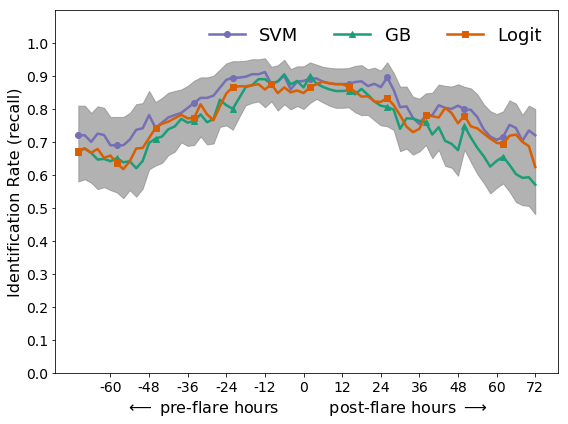

In [20]:
#Obtain machine prediction for pre-post flare training data using SVM, Logit and GB
matplotlib.rcParams['figure.figsize'] = [8, 6]
meanY = {}
stdY = {}
machines = ['SVM','GB','Logit']
totalSpan = 144 #Hours from pre-flare to post flare
obsPerHour = 5  
averagePeriod = 2
NBINS = totalSpan/averagePeriod #Averaged machine outputs over two hour bins
for machine in machines:
    clf = trainer.getClassifier(dataPath,machine_type=machine)
    files = glob.glob(dataPath + '/aligned/flaring/train/*.dat')
    yPrePost = []
    for i in xrange(NBINS):
        yPrePost.append([])
    for f in files:
        obs = np.load(f)
        x = obs[:,:-1]
        for i in xrange(nFeatures):
            x[:,i] -= means[i]
            x[:,i] /= stds[i]
        y = np.zeros((len(obs),2),dtype=np.float)
        y[:,0] = clf.predict(x)
        y[:,1] = obs[:,-1]
        y = smoothenSample(y)
        invalidIndices = np.argwhere(y[:,1]==0.0).flatten()
        y[invalidIndices,0] = 0.0 
        validIndices = np.argwhere(y[:,1]==1.0).flatten()
        for ind in validIndices:
            yPrePost[ind].append(y[ind,0])
    yPrePostMean = np.zeros(NBINS)
    yPrePostStd = np.zeros(NBINS)
    for i in xrange(NBINS):
        yPrePostMean[i] = np.mean(yPrePost[i])
        yPrePostStd[i] = np.std(yPrePost[i])/np.sqrt(len(yPrePost[i]))
    meanY[machine] = yPrePostMean
    stdY[machine]  = yPrePostStd

LB=16
TK=14
LG=18
prepostHours = np.arange(-70.0,74.0,2.0)
yUppLim = np.zeros(prepostHours.shape[0],dtype=np.float)
yLowLim = np.ones(prepostHours.shape[0],dtype=np.float)
colors = {'SVM':'#7570b3','Logit':'#d95f02','GB':'#1b9e77','XGB':'#e7298a'} 
markers = {'SVM':'o','Logit':'s','GB':'^','XGB':'*'} 
fig = pl.figure()
ax = fig.add_subplot(111)
for machine in machines:
    machineUppLim = meanY[machine] + stdY[machine]
    machineLowLim = meanY[machine] - stdY[machine]
    yUppLim = np.maximum(yUppLim,machineUppLim)
    yLowLim = np.minimum(yLowLim,machineLowLim)
    ax.plot(prepostHours,meanY[machine],color=colors[machine],marker=markers[machine],label=machine,lw=2.5,
           markevery=6)
ax.fill_between(prepostHours, yUppLim, yLowLim, color = 'grey', alpha = 0.6)
ax.set_xlabel(r'$\longleftarrow$ pre-flare hours          post-flare hours $\longrightarrow$',fontsize=LB)
ax.set_ylabel('Identification Rate (recall)',fontsize=LB)
ax.legend(loc=1, frameon = False, ncol=3,fontsize=LG)
ax.set_xticks(np.arange(-60,78,12))
ax.set_xticklabels(np.arange(-60,78,12),fontsize=TK)
ax.set_ylim((0.0,1.1))
ax.set_yticks(np.arange(0.0,1.1,0.1))
ax.set_yticklabels(np.arange(0.0,1.1,0.1),fontsize=TK)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
pl.tight_layout()
pl.show()

## Time evolution of flaring ARs from 72 hours pre-flare to 72 hours post-flare

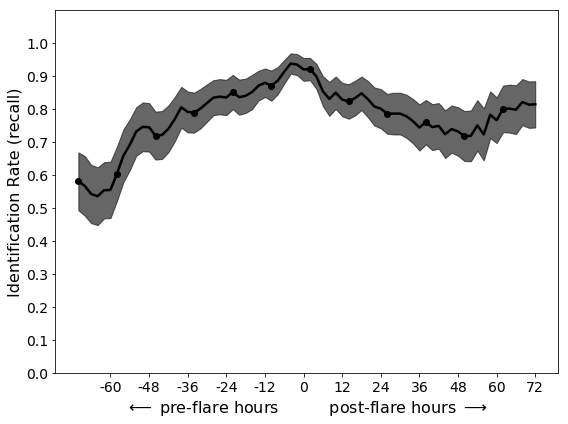

In [21]:
#Obtain machine prediction for pre-post flare test data using SVM
matplotlib.rcParams['figure.figsize'] = [8, 6]
totalSpan = 144 #Hours from pre-flare to post flare
obsPerHour = 5  
averagePeriod = 2
NBINS = totalSpan/averagePeriod #Averaged machine outputs over two hour bins
clf = trainer.getClassifier(dataPath,machine_type='SVM')
files = glob.glob(dataPath + '/aligned/flaring/test/*.dat')
yPrePost = []
for i in xrange(NBINS):
    yPrePost.append([])
for f in files:
    obs = np.load(f)
    x = obs[:,:-1]
    for i in xrange(nFeatures):
        x[:,i] -= means[i]
        x[:,i] /= stds[i]
    y = np.zeros((len(obs),2),dtype=np.float)
    y[:,0] = clf.predict(x)
    y[:,1] = obs[:,-1]
    invalidIndices = np.argwhere(y[:,1]==0.0).flatten()
    y[invalidIndices,0] = 0.0 
    y = smoothenSample(y)
    validIndices = np.argwhere(y[:,1]==1.0).flatten()
    for ind in validIndices:
        yPrePost[ind].append(y[ind,0])
yPrePostMean = np.zeros(NBINS)
yPrePostStd = np.zeros(NBINS)
for i in xrange(NBINS):
    yPrePostMean[i] = np.mean(yPrePost[i])
    yPrePostStd[i] = np.std(yPrePost[i])/np.sqrt(len(yPrePost[i]))
LB=16
TK=14
LG=18
prepostHours = np.arange(-70.0,74.0,2.0)
fig = pl.figure()
ax = fig.add_subplot(111)
yUppLim = yPrePostMean + yPrePostStd
yLowLim = yPrePostMean - yPrePostStd
ax.plot(prepostHours,yPrePostMean,color='k',marker='o',lw=2.5,markevery=6)
ax.fill_between(prepostHours, yUppLim, yLowLim, color = 'k', alpha = 0.6)
ax.set_xlabel(r'$\longleftarrow$ pre-flare hours          post-flare hours $\longrightarrow$',fontsize=LB)
ax.set_ylabel('Identification Rate (recall)',fontsize=LB)
ax.set_xticks(np.arange(-60,78,12))
ax.set_xticklabels(np.arange(-60,78,12),fontsize=TK)
ax.set_ylim((0.0,1.1))
ax.set_yticks(np.arange(0.0,1.1,0.1))
ax.set_yticklabels(np.arange(0.0,1.1,0.1),fontsize=TK)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
pl.tight_layout()
pl.show()

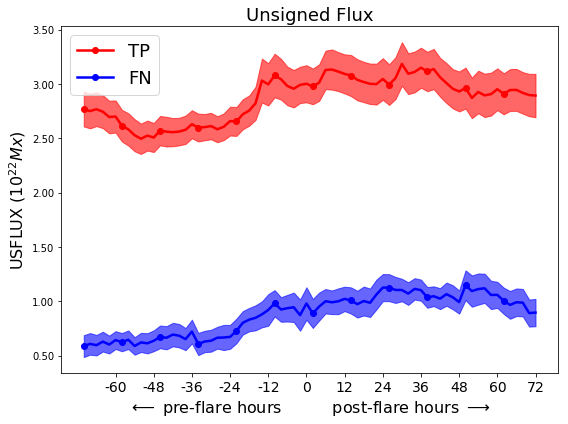

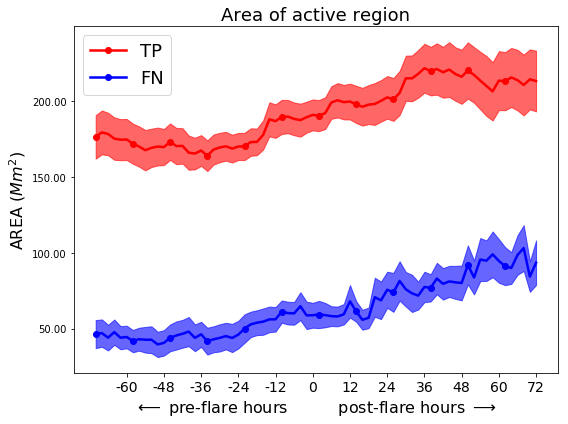

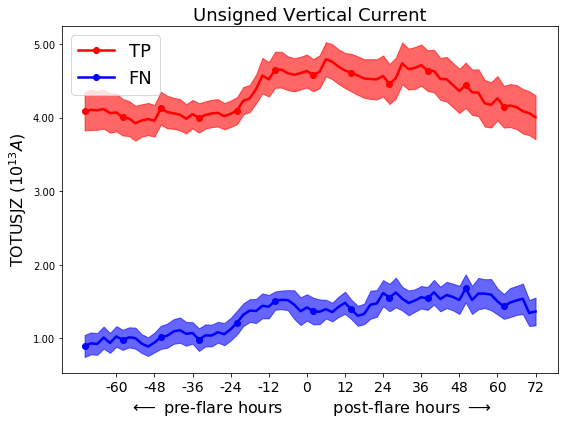

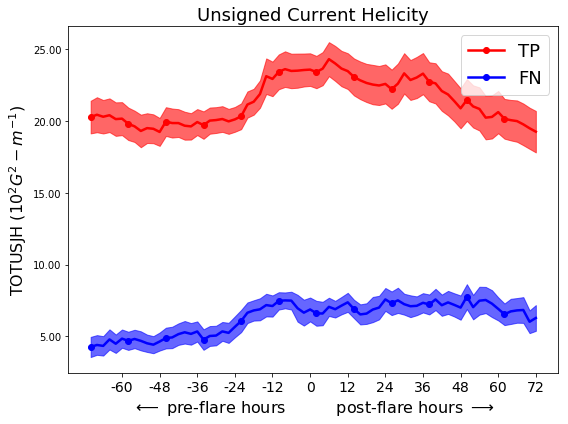

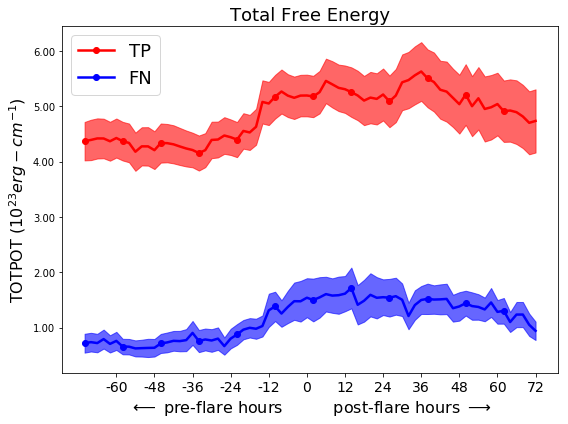

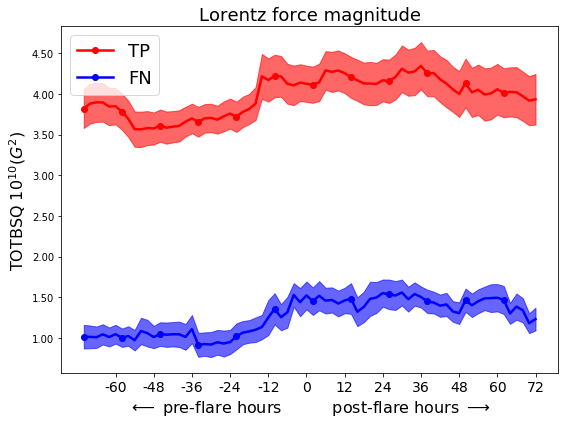

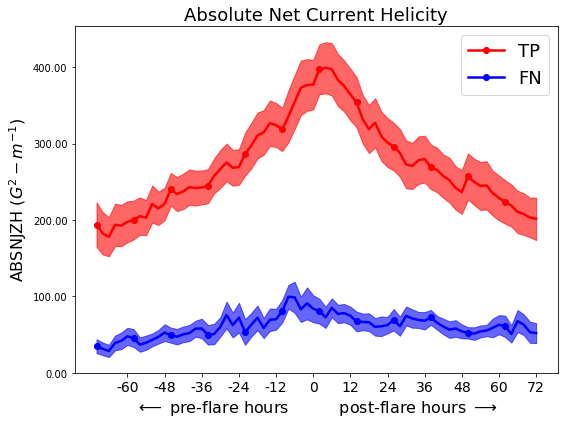

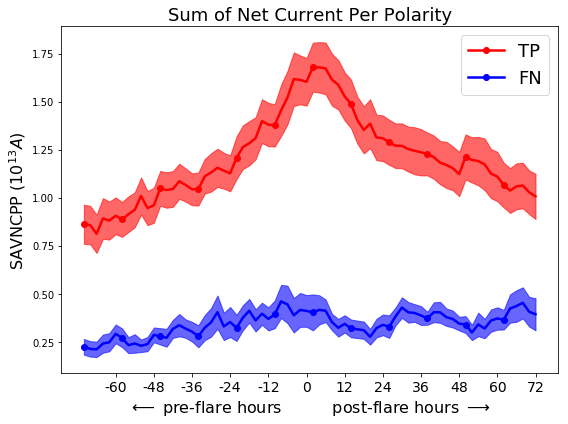

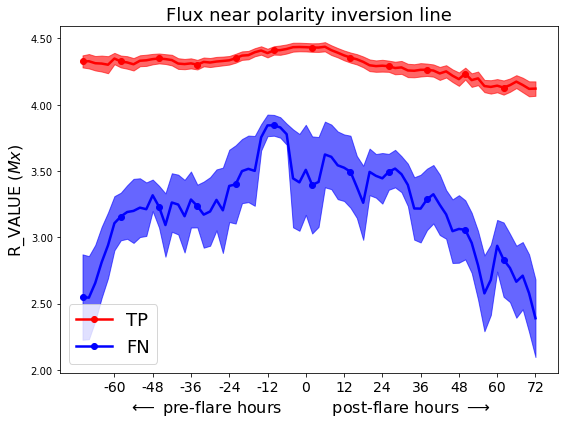

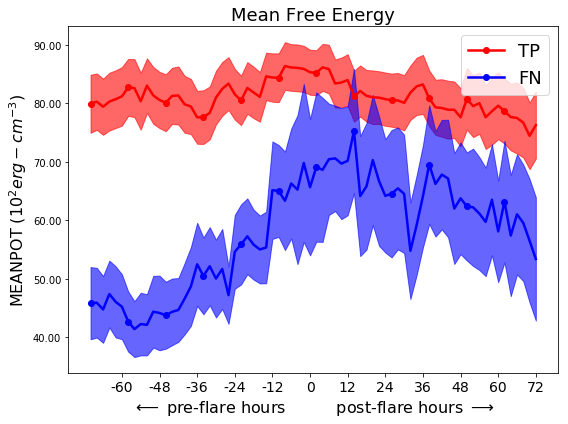

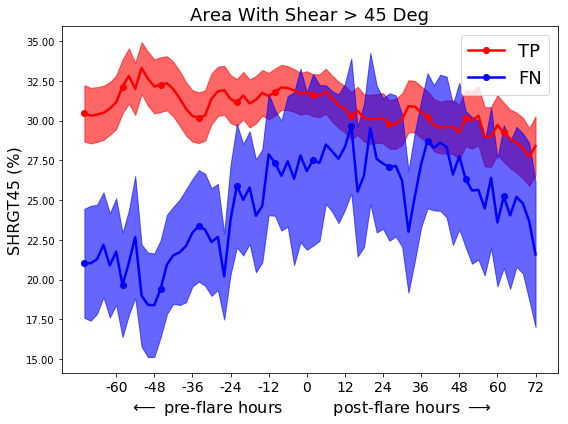

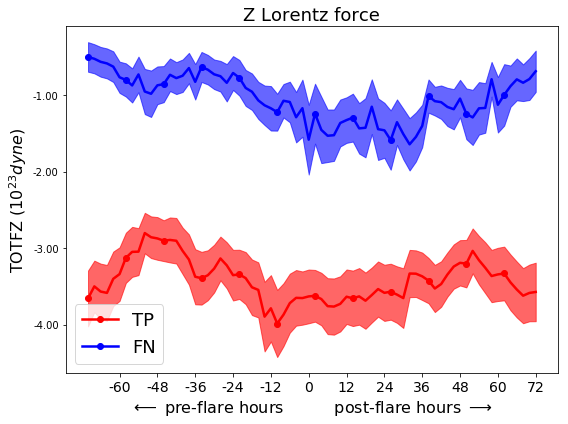

In [22]:
#Obtain SHARP feature mean values over TP and FN populations as classified using SVM
matplotlib.rcParams['figure.figsize'] = [8, 6]
totalSpan = 144 #Hours from pre-flare to post flare
obsPerHour = 5  
averagePeriod = 2
NBINS = totalSpan/averagePeriod #Averaged machine outputs over two hour bins
clf = trainer.getClassifier(dataPath,machine_type='SVM')
files = glob.glob(dataPath + '/aligned/flaring/test/*.dat')
files += glob.glob(dataPath + '/aligned/flaring/train/*.dat')

X_TPs = [] 
X_FNs = [] 
for i in xrange(nFeatures):
    X_TPs.append([])
    X_FNs.append([])
for i in xrange(nFeatures):
    for j in xrange(NBINS):
        X_TPs[i].append([])
        X_FNs[i].append([])

X_TPs_means = np.empty((nFeatures,NBINS),dtype = np.float) 
X_FNs_means = np.empty((nFeatures,NBINS),dtype = np.float) 

X_TPs_sds = np.empty((nFeatures,NBINS),dtype = np.float) 
X_FNs_sds = np.empty((nFeatures,NBINS),dtype = np.float) 

X_TPs_pos_lim = np.empty((nFeatures,NBINS),dtype = np.float) 
X_FNs_pos_lim = np.empty((nFeatures,NBINS),dtype = np.float) 

X_TPs_neg_lim = np.empty((nFeatures,NBINS),dtype = np.float) 
X_FNs_neg_lim = np.empty((nFeatures,NBINS),dtype = np.float) 

for f in files:
    nx = np.load(f)
    x = np.copy(nx)
    for i in xrange(nFeatures):
        x[:,i] -= means[i]
        x[:,i] /= stds[i]
    y = np.zeros((len(nx),2),dtype = np.float)
    y[:,0] = clf.predict(x[:,:-1])
    y[:,1] = x[:,-1] 

    invalidIndices = np.argwhere(y[:,1]==0.0).flatten()
    y[invalidIndices,0] = 0.0 
    y = smoothenSample(y)
    validIndices = np.argwhere(y[:,1]==1.0).flatten()
    for j,i in enumerate(xInd):
        this_x = np.zeros((len(nx),2),dtype = np.float)
        this_x[:,0] = nx[:,i]
        this_x[:,1] = nx[:,-1]
        this_x = smoothenSample(this_x)
        for index in validIndices:
            if y[index][0] >= 0.5:
                X_TPs[i][index].append(this_x[index][0])
                X_TPs[i][index][-1] = X_TPs[i][index][-1]/featScales[j]
            else:
                X_FNs[i][index].append(this_x[index][0])
                X_FNs[i][index][-1] = X_FNs[i][index][-1]/featScales[j]

for i in xrange(NBINS):
    for j in xrange(nFeatures):
        X_TPs_means[j][i] = np.mean(X_TPs[j][i]) 
        X_FNs_means[j][i] = np.mean(X_FNs[j][i])

        X_TPs_sds[j][i] = np.std(X_TPs[j][i])/np.sqrt(len(X_TPs[j][i])) 
        X_FNs_sds[j][i] = np.std(X_FNs[j][i])/np.sqrt(len(X_FNs[j][i]))

        X_TPs_pos_lim[j][i] = X_TPs_means[j][i] + X_TPs_sds[j][i] 
        X_FNs_pos_lim[j][i] = X_FNs_means[j][i] + X_FNs_sds[j][i]

        X_TPs_neg_lim[j][i] = X_TPs_means[j][i] - X_TPs_sds[j][i]
        X_FNs_neg_lim[j][i] = X_FNs_means[j][i] - X_FNs_sds[j][i]

LB=16
TK=14
LG=18
prepostHours = np.arange(-70.0,74.0,2.0)
for j,i in enumerate(xInd):
    fig = pl.figure()
    ax = fig.add_subplot(111)
    ax.set_title('%s'%features[j],fontsize=LG)
    ax.plot(prepostHours,X_TPs_means[i],color='r',marker='o',lw=2.5,markevery=6,label='TP')
    ax.fill_between(prepostHours, X_TPs_pos_lim[i], X_TPs_neg_lim[i], color = 'r', alpha = 0.6)
    ax.plot(prepostHours,X_FNs_means[i],color='b',marker='o',lw=2.5,markevery=6,label='FN')
    ax.fill_between(prepostHours, X_FNs_pos_lim[i], X_FNs_neg_lim[i], color = 'b', alpha = 0.6)
    ax.set_xlabel(r'$\longleftarrow$ pre-flare hours          post-flare hours $\longrightarrow$',fontsize=LB)
    ax.set_ylabel('%s %s'%(featAbb[j],featUnits[j]),fontsize=LB)
    ax.legend(loc=0,fontsize=LG)
    ax.set_xticks(np.arange(-60,78,12))
    ax.set_xticklabels(np.arange(-60,78,12),fontsize=TK)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    pl.tight_layout()
    pl.show()

## Comparison of flaring and non-flaring ARs

In [10]:
#Obtain machine prediction for flaring AR samples > 72 hours from flare (quiet) and non-flaring AR samples in test data
quietX = np.load(dataPath + '/aligned/flaring/quiet_test.dat')
for i in xrange(nFeatures):
    quietX[:,i] -= means[i]
    quietX[:,i] /= stds[i]
clf = trainer.getClassifier(dataPath,machine_type='SVM')
quietY = clf.predict(quietX)
meanQuietY = np.mean(quietY)
stdQuietY = np.std(quietY)/np.sqrt(len(quietY))
print '#Test Samples > 72 hr from flare: %d'%len(quietX)
print 'Recall > 72 hr from flare: %0.4f +/- %0.4f'%(meanQuietY,stdQuietY)

noflX = np.load(dataPath + '/nonflaring/test.dat')
for i in xrange(nFeatures):
    noflX[:,i] -= means[i]
    noflX[:,i] /= stds[i]
noflY = clf.predict(noflX)
meanNoflY = np.mean(noflY)
stdNoflY = np.std(noflY)/np.sqrt(len(noflY))
print '#Nonflaring Test Samples: %d'%len(noflX)
print 'Nonflaring Recall: %0.4f +/- %0.4f'%(1-meanNoflY,stdNoflY)

#Test Samples > 72 hr from flare: 8294
Recall > 72 hr from flare: 0.7524 +/- 0.0047
#Nonflaring Test Samples: 151498
Nonflaring Recall: 0.9254 +/- 0.0007


In [11]:
#Mean values of TP,FN,FP,TN subpopulations for flaring AR samples > 72 hour from flares and non-flaring ARs
quietX = np.load(dataPath + '/aligned/flaring/quiet_test.dat')
CquietX = np.copy(quietX)
for i in xrange(nFeatures):
    quietX[:,i] -= means[i]
    quietX[:,i] /= stds[i]
clf = trainer.getClassifier(dataPath,machine_type='SVM')
quietY = clf.predict(quietX)

TPs = CquietX[np.argwhere(quietY==1).flatten()]
FNs = CquietX[np.argwhere(quietY==0).flatten()]
for j,i in enumerate(xInd):
    TPs[:,i] /= featScales[j]
    FNs[:,i] /= featScales[j]
meanTPs = np.zeros(nFeatures)
stdTPs = np.zeros(nFeatures)
meanFNs = np.zeros(nFeatures)
stdFNs = np.zeros(nFeatures)
for i in xrange(nFeatures):
    meanTPs[i] = np.mean(TPs[:,i])
    stdTPs[i]  = np.std(TPs[:,i])/np.sqrt(len(TPs[:,i]))
    meanFNs[i] = np.mean(FNs[:,i])
    stdFNs[i] = np.std(FNs[:,i])/np.sqrt(len(FNs[:,i]))

noflX = np.load(dataPath + '/nonflaring/test.dat')
CnoflX = np.copy(noflX)
for i in xrange(nFeatures):
    noflX[:,i] -= means[i]
    noflX[:,i] /= stds[i]
noflY = clf.predict(noflX)

FPs = CnoflX[np.argwhere(noflY==1).flatten()]
TNs = CnoflX[np.argwhere(noflY==0).flatten()]
for j,i in enumerate(xInd):
    FPs[:,i] /= featScales[j]
    TNs[:,i] /= featScales[j]
meanTNs = np.zeros(nFeatures)
stdTNs = np.zeros(nFeatures)
meanFPs = np.zeros(nFeatures)
stdFPs = np.zeros(nFeatures)
for i in xrange(nFeatures):
    meanTNs[i] = np.mean(TNs[:,i])
    stdTNs[i]  = np.std(TNs[:,i])/np.sqrt(len(TNs[:,i]))
    meanFPs[i] = np.mean(FPs[:,i])
    stdFPs[i] = np.std(FPs[:,i])/np.sqrt(len(FPs[:,i]))

print 'Feature\t\tTP\t\t\tFN\t\t\tFP\t\t\tTN\t\t(TP-TN)/SD(TN)'
for j,i in enumerate(xInd):
    print '%s\t%0.4f +/- %0.4f\t%0.4f +/- %0.4f\t%0.4f +/- %0.4f\t%0.4f +/- %0.4f\t%0.4f'%(featAbb[j],meanTPs[i],stdTPs[i],meanFNs[i],
                                                                                          stdFNs[i],meanFPs[i],
                                                                                          stdFPs[i],meanTNs[i],
                                                                                          stdTNs[i],abs(meanTPs[i]-meanTNs[i])/stdTNs[i])

Feature		TP			FN			FP			TN		(TP-TN)/SD(TN)
USFLUX	3.5367 +/- 0.0249	1.2797 +/- 0.0123	2.2533 +/- 0.0096	0.4838 +/- 0.0010	3119.4136
AREA	291.9884 +/- 1.6905	140.9216 +/- 0.9316	205.7365 +/- 0.9767	53.7644 +/- 0.1075	2216.2109
TOTUSJZ	5.4003 +/- 0.0355	2.0265 +/- 0.0252	3.7753 +/- 0.0158	0.7813 +/- 0.0015	2982.7641
TOTUSJH	25.4205 +/- 0.1719	9.3155 +/- 0.0724	17.8461 +/- 0.0722	3.6592 +/- 0.0071	3044.4764
TOTPOT	5.4794 +/- 0.0528	1.6651 +/- 0.0319	4.7641 +/- 0.0297	0.6187 +/- 0.0022	2215.8878
TOTBSQ	4.9442 +/- 0.0367	1.7525 +/- 0.0157	3.4187 +/- 0.0160	0.7335 +/- 0.0015	2890.5083
ABSNJZH	255.4612 +/- 2.8623	60.3175 +/- 0.8397	238.2945 +/- 1.8447	37.2829 +/- 0.1099	1985.1391
SAVNCPP	1.1339 +/- 0.0082	0.4342 +/- 0.0065	1.0192 +/- 0.0067	0.2095 +/- 0.0005	1925.1599
R_VALUE	4.1064 +/- 0.0062	3.2979 +/- 0.0142	4.1114 +/- 0.0039	2.1158 +/- 0.0040	502.9079
MEANPOT	71.2950 +/- 0.3905	58.3007 +/- 0.7939	95.7517 +/- 0.3464	45.1434 +/- 0.0961	272.1093
SHRGT45	28.0891 +/- 0.1552	24.9985 +/- 0.3192	

## Analysis of emerging flaring ARs before first flares

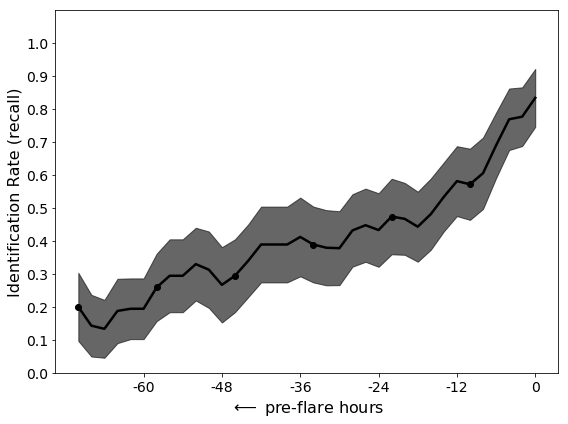

In [23]:
#Obtain machine prediction for pre first flare on emerging AR using SVM
totalSpan = 72 #Pre-flare hours
obsPerHour = 5  
averagePeriod = 2
NBINS = totalSpan/averagePeriod #Averaged machine outputs over two hour bins
clf = trainer.getClassifier(dataPath,machine_type='SVM')
files = glob.glob(dataPath + '/aligned/flaring/emerging/*.dat')
yPrePost = []
for i in xrange(NBINS):
    yPrePost.append([])
for f in files:
    obs = np.load(f)
    x = obs[:,:-1]
    for i in xrange(nFeatures):
        x[:,i] -= means[i]
        x[:,i] /= stds[i]
    y = np.zeros((len(obs),2),dtype=np.float)
    y[:,0] = clf.predict(x)
    y[:,1] = obs[:,-1]
    invalidIndices = np.argwhere(y[:,1]==0.0).flatten()
    y[invalidIndices,0] = 0.0 
    y = smoothenSample(y)
    validIndices = np.argwhere(y[:,1]==1.0).flatten()
    for ind in validIndices:
        yPrePost[ind].append(y[ind,0])
yPrePostMean = np.zeros(NBINS)
yPrePostStd = np.zeros(NBINS)
for i in xrange(NBINS):
    yPrePostMean[i] = np.mean(yPrePost[i])
    yPrePostStd[i] = np.std(yPrePost[i])/np.sqrt(len(yPrePost[i]))
LB=16
TK=14
LG=18
prepostHours = np.arange(-70.0,2.0,2.0)
fig = pl.figure()
ax = fig.add_subplot(111)
yUppLim = yPrePostMean + yPrePostStd
yLowLim = yPrePostMean - yPrePostStd
ax.plot(prepostHours,yPrePostMean,color='k',marker='o',lw=2.5,markevery=6)
ax.fill_between(prepostHours, yUppLim, yLowLim, color = 'k', alpha = 0.6)
ax.set_xlabel(r'$\longleftarrow$ pre-flare hours',fontsize=LB)
ax.set_ylabel('Identification Rate (recall)',fontsize=LB)
ax.set_xticks(np.arange(-60,12,12))
ax.set_xticklabels(np.arange(-60,12,12),fontsize=TK)
ax.set_ylim((0.0,1.1))
ax.set_yticks(np.arange(0.0,1.1,0.1))
ax.set_yticklabels(np.arange(0.0,1.1,0.1),fontsize=TK)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
pl.tight_layout()
pl.show()

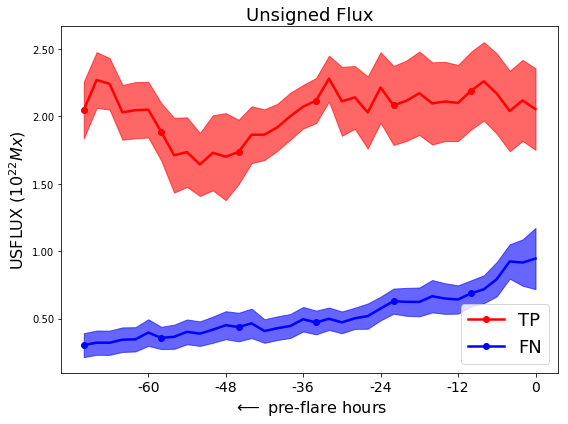

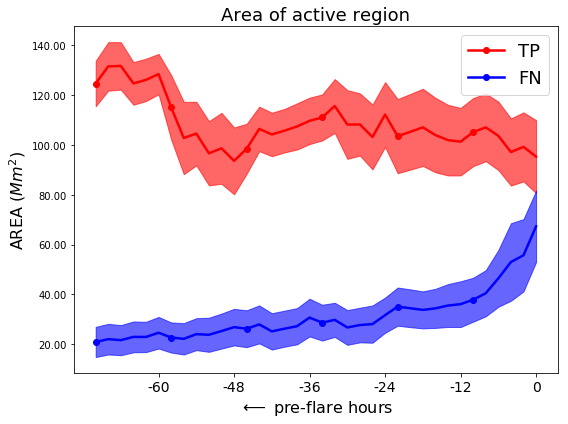

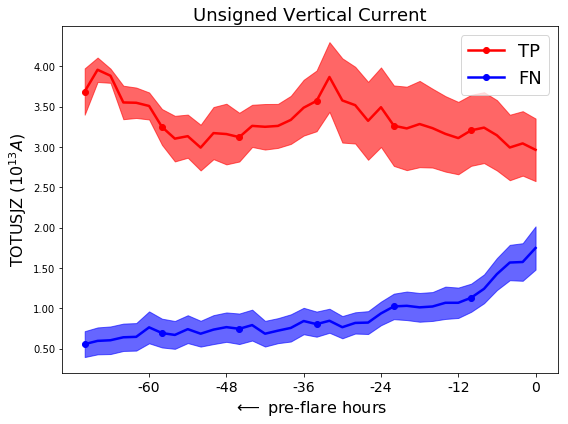

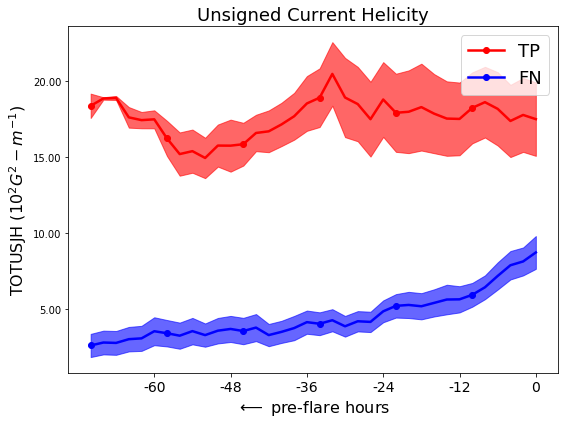

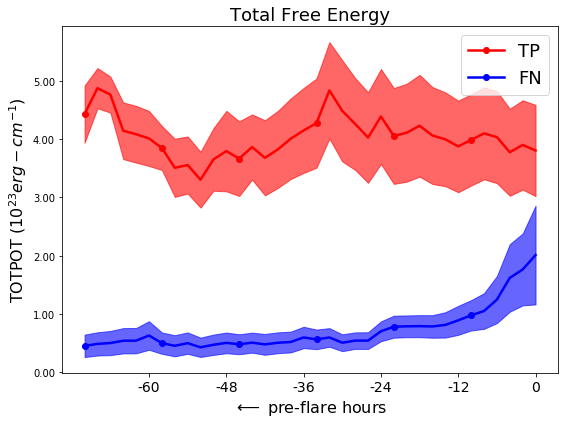

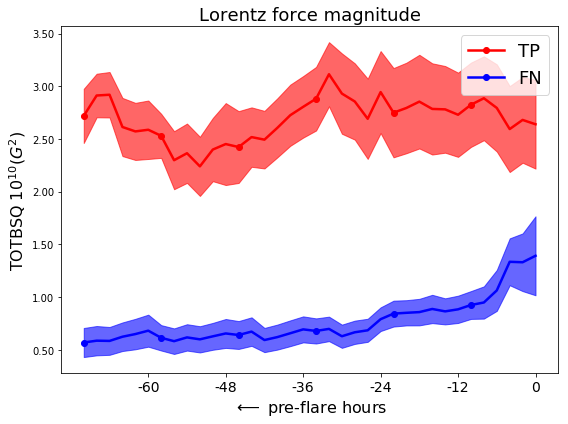

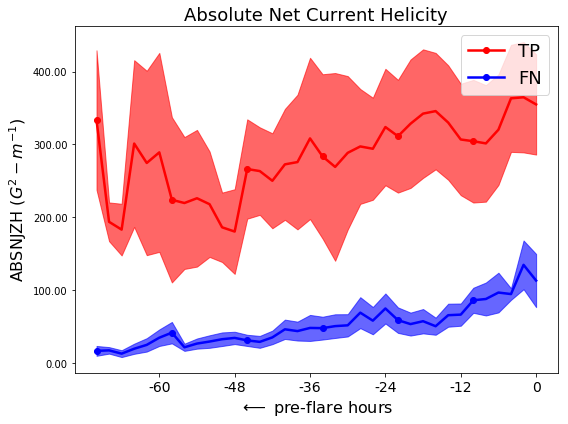

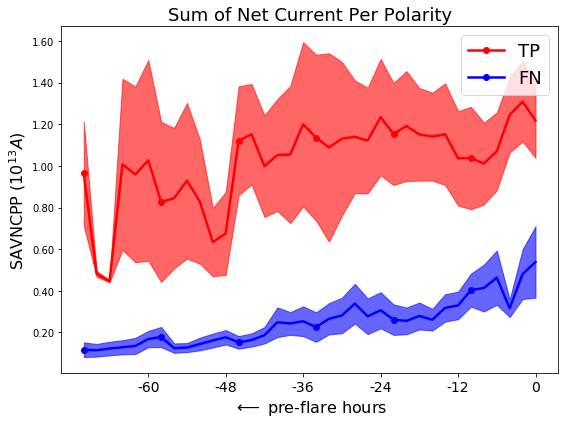

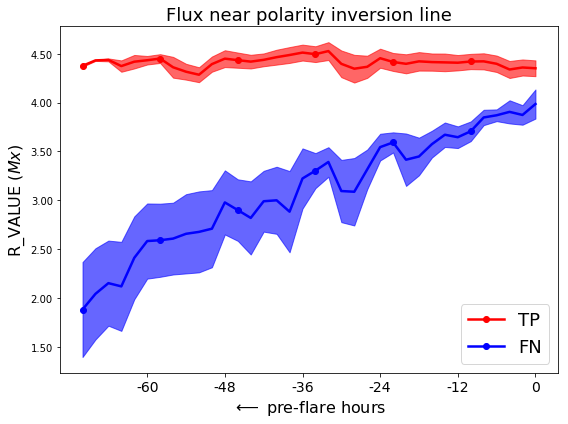

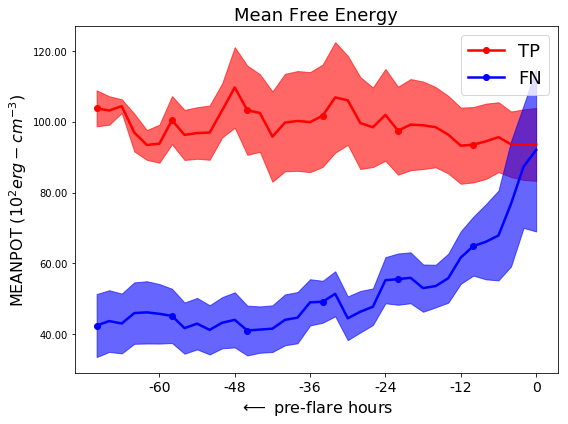

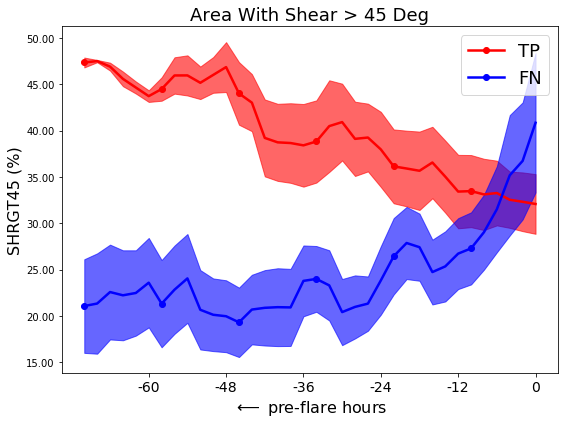

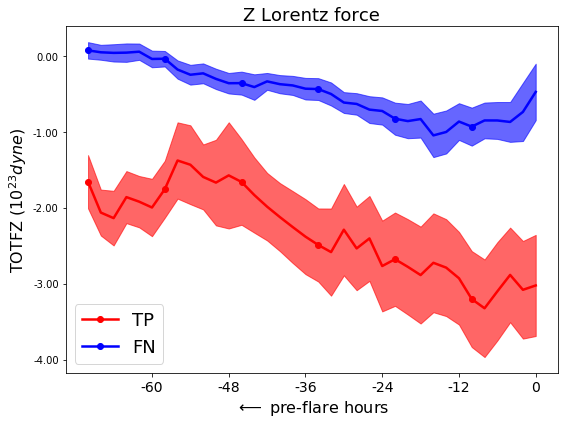

In [24]:
#Obtain mean values of SHARPs over TP,FN subpopulation as classified by SVM
totalSpan = 72 #Pre-flare hours
obsPerHour = 5  
averagePeriod = 2
NBINS = totalSpan/averagePeriod #Averaged machine outputs over two hour bins
clf = trainer.getClassifier(dataPath,machine_type='SVM')
files = glob.glob(dataPath + '/aligned/flaring/emerging/*.dat')

X_TPs = [] 
X_FNs = [] 
for i in xrange(nFeatures):
    X_TPs.append([])
    X_FNs.append([])
for i in xrange(nFeatures):
    for j in xrange(NBINS):
        X_TPs[i].append([])
        X_FNs[i].append([])

X_TPs_means = np.empty((nFeatures,NBINS),dtype = np.float) 
X_FNs_means = np.empty((nFeatures,NBINS),dtype = np.float) 

X_TPs_sds = np.empty((nFeatures,NBINS),dtype = np.float) 
X_FNs_sds = np.empty((nFeatures,NBINS),dtype = np.float) 

X_TPs_pos_lim = np.empty((nFeatures,NBINS),dtype = np.float) 
X_FNs_pos_lim = np.empty((nFeatures,NBINS),dtype = np.float) 

X_TPs_neg_lim = np.empty((nFeatures,NBINS),dtype = np.float) 
X_FNs_neg_lim = np.empty((nFeatures,NBINS),dtype = np.float) 

for f in files:
    nx = np.load(f)
    x = np.copy(nx)
    for i in xrange(nFeatures):
        x[:,i] -= means[i]
        x[:,i] /= stds[i]
    y = np.zeros((len(nx),2),dtype = np.float)
    y[:,0] = clf.predict(x[:,:-1])
    y[:,1] = x[:,-1] 

    invalidIndices = np.argwhere(y[:,1]==0.0).flatten()
    y[invalidIndices,0] = 0.0 
    y = smoothenSample(y)
    validIndices = np.argwhere(y[:,1]==1.0).flatten()
    for j,i in enumerate(xInd):
        this_x = np.zeros((len(nx),2),dtype = np.float)
        this_x[:,0] = nx[:,i]
        this_x[:,1] = nx[:,-1]
        this_x = smoothenSample(this_x)
        for index in validIndices:
            if y[index][0] >= 0.5:
                X_TPs[i][index].append(this_x[index][0])
                X_TPs[i][index][-1] = X_TPs[i][index][-1]/featScales[j]
            else:
                X_FNs[i][index].append(this_x[index][0])
                X_FNs[i][index][-1] = X_FNs[i][index][-1]/featScales[j]

for i in xrange(NBINS):
    for j in xrange(nFeatures):
        X_TPs_means[j][i] = np.mean(X_TPs[j][i]) 
        X_FNs_means[j][i] = np.mean(X_FNs[j][i])

        X_TPs_sds[j][i] = np.std(X_TPs[j][i])/np.sqrt(len(X_TPs[j][i])) 
        X_FNs_sds[j][i] = np.std(X_FNs[j][i])/np.sqrt(len(X_FNs[j][i]))

        X_TPs_pos_lim[j][i] = X_TPs_means[j][i] + X_TPs_sds[j][i] 
        X_FNs_pos_lim[j][i] = X_FNs_means[j][i] + X_FNs_sds[j][i]

        X_TPs_neg_lim[j][i] = X_TPs_means[j][i] - X_TPs_sds[j][i]
        X_FNs_neg_lim[j][i] = X_FNs_means[j][i] - X_FNs_sds[j][i]

LB=16
TK=14
LG=18
prepostHours = np.arange(-70.0,2.0,2.0)
for j,i in enumerate(xInd):
    fig = pl.figure()
    ax = fig.add_subplot(111)
    ax.set_title('%s'%features[j],fontsize=LG)
    ax.plot(prepostHours,X_TPs_means[i],color='r',marker='o',lw=2.5,markevery=6,label='TP')
    ax.fill_between(prepostHours, X_TPs_pos_lim[i], X_TPs_neg_lim[i], color = 'r', alpha = 0.6)
    ax.plot(prepostHours,X_FNs_means[i],color='b',marker='o',lw=2.5,markevery=6,label='FN')
    ax.fill_between(prepostHours, X_FNs_pos_lim[i], X_FNs_neg_lim[i], color = 'b', alpha = 0.6)
    ax.set_xlabel(r'$\longleftarrow$ pre-flare hours',fontsize=LB)
    ax.set_ylabel('%s %s'%(featAbb[j],featUnits[j]),fontsize=LB)
    ax.legend(loc=0,fontsize=LG)
    ax.set_xticks(np.arange(-60,12,12))
    ax.set_xticklabels(np.arange(-60,12,12),fontsize=TK)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    pl.tight_layout()
    pl.show()

## Correlation between SHARP features

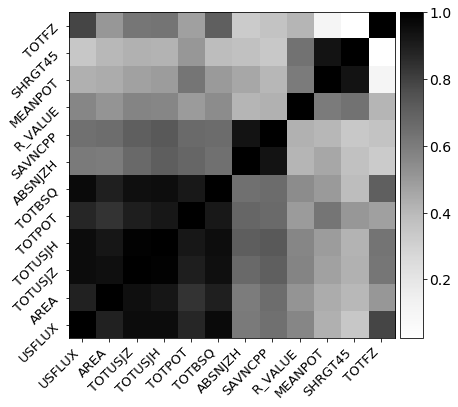

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams['figure.figsize'] = [8, 6]
Covr = processor.getFeatureCorrelations(dataPath,sharpName)
fig = pl.figure()
ax = fig.add_subplot(111)
im = ax.imshow(Covr,cmap=pl.get_cmap('Greys'))
ax.set_xticks(np.arange(0.0,12.0,1))
ax.set_xticklabels(featAbb, rotation = 45, fontsize=13, ha='right')
ax.set_yticks(np.arange(0.0,12.0,1))
ax.set_yticklabels(featAbb, rotation = 45, fontsize=13)
ax.set_ylim((-0.5,11.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.07)
cbar = pl.colorbar(im, cax=cax)
cbar.ax.set_yticklabels([0.2,0.4,0.6,0.8,1.0],fontsize=14)
pl.show()